In [ ]:
import pandas as pd

# df = pd.read_csv('../data/sales.csv')
df = pd.read_csv('sales.csv')
df.dropna(subset=['price'], inplace=True)

In [ ]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year 
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

In [ ]:
class Cost_Transformer(object):
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        self.mean = df.mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        return df.fillna(self.mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def cost2num(self, x):
        if type(x) == str: 
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x

In [ ]:
features = list(train_raw.columns)
target = 'price'
features.remove(target)

In [ ]:
def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

In [ ]:
X = train_raw[features]
y = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

# 1. train_test_split

In [ ]:
from sklearn.model_selection import train_test_split

**Example:** Split training data in to new training data and validation data.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y, 
                                                      test_size=0.2, 
                                                      random_state=2019)

### random_state: the seed of the pseudo random generator. Please do define it whenever you have a random process, to make your results reproducible.

**Example:** Find the best **alpha** for Lasso using **validation score**.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
alphas = range(1, 30)
# alphas = [0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5, 6]
mse = []
for alpha in alphas:
    steps = [('ctf', Cost_Transformer()),
             ('poly', PolynomialFeatures(degree=30)),
             ('rescale', MinMaxScaler()),
             ('lr', Lasso(alpha=alpha, max_iter=100000))]
    model = Pipeline(steps)
    model = model.fit(X_train, y_train)
    mse.append(mean_squared_error(y_valid, model.predict(X_valid)))

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline

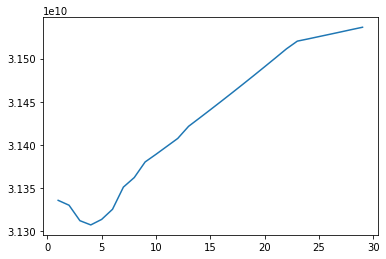

In [ ]:
plt.plot(alphas, mse)

<font color='red'>Question:</font> What are training, validation, and testing data for? Why don't we directly use testing score/loss to find the best **alpha**?

### <font color = 'blue'> Is it ok that I changed the range of alpha? </font>

### Training data: The set of data we use to fit the model.
### Validation data: The data set used to evaluate a model fit on the training set while tuning model hyperparameters. 
### Test data: The data set used to evaluate a final model fit on the training dataset.
### If we use the test set to find the best alpha then evaulate the model on the same test set, our result will be too optimistic. We should only use the test set once for the final evaluation.

# 2. K-fold Cross Validation

<font color='red'>Assignment:</font> Use **KFold** instead of **train_test_split** to find the best **alpha**. Please note that X is a DataFrame rather than Numpy Array. Our solution will be a little different from the example in Sklearn tutorial. You will need **iloc** here.

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits = 5)

### how is the splits looks like?

In [ ]:
# by default: no shuffle
i = 1
for train_index, valid_index in kf.split(X): # generator
    print('Split {}'.format(i), train_index, valid_index, sep='\n')
    i += 1

Split 1
[ 552  553  554 ... 2754 2755 2756]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 23

In [ ]:
import numpy as np

alphas = range(1, 30)
# alphas = [0.1, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5, 6]
err_alphas = []
for alpha in alphas:
    steps = [('ctf', Cost_Transformer()),
             ('poly', PolynomialFeatures(degree = 30)),
             ('rescale', MinMaxScaler()),
             ('lr', Lasso(alpha = alpha, max_iter = 100000))]
    mse_kf = []
    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        model_kf = Pipeline(steps)
        model_kf = model_kf.fit(X_train, y_train)
        mse_kf.append(mean_squared_error(y_valid, model_kf.predict(X_valid)))
    err_alphas.append(np.mean(mse_kf))

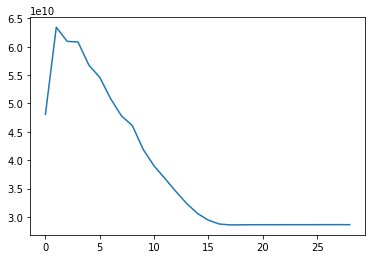

In [ ]:
plt.plot(err_alphas)

<font color='red'>Question:</font> What is the difference between **KFold** and **train_test_split**? What is the advantages and disadvanteges of k-fold cross validation?

### train_test_split introduces bias since you are not using all of your data, while KFold uses all the data.
### train_test_split: pros: (1) Fully independent data (2) only needs to run once therefore low computational cost. cons: Introduces bias
### KFold: pros: <font color='red'>Less bias</font>. cons: needs to run K times, therefore high computational cost.

<font color='red'>Some answers:</font> train_test_split splits 2-fold, while Kfold can split more

<font color='red'>k = 2, still different from train_test_split</font>

### <font color='red'>Q:</font> some more questions
1. what is the best alpha?
2. will the best alpha change, if you change k in kFold?
3. how to determine k?

In [ ]:
full data 
[data cal, data ten]

### <font color='red'>Q:</font> high standard diviation of MSE with CV?
![image.png](attachment:image.png)

# 3. GridSearchCV

<font color='red'>Assignment:</font> By now, we have only tuned the value of **alpha**. Actually, **degree** in **PolynomialFeatures** is also a hyper parameter. Can we find the best values for both of them? You can try to use **GridSearchCV**, and also **make_scorer**.

### if not sure how to use GridSearchCV, go read the examples in the sklearn documentation

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#### step 1: define the hyperparameters to tune

In [ ]:
parameters = {'lasso__alpha': range(1,10), 'poly__degree': range(1,10)}

#### step 2: define the scorer

<font color='red'>Don't forget to set greater_is_better = False</font>

In [ ]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

#### step 3: create model/pipeline

In [ ]:
steps = [('ctf', Cost_Transformer()),
        ('poly', PolynomialFeatures()),
        ('rescale', MinMaxScaler()),
        ('lasso', Lasso())]
pipe = Pipeline(steps)

#### step 4: define a gridsearch process

In [ ]:
model_gsv = GridSearchCV(pipe, parameters, cv = 5, scoring = scorer)

In [ ]:
model_gsv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ctf',
                                        <__main__.Cost_Transformer object at 0x0000023EE9216490>),
                                       ('poly', PolynomialFeatures()),
                                       ('rescale', MinMaxScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': range(1, 10),
                         'poly__degree': range(1, 10)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

#### step 5: search

In [ ]:
import warnings
warnings.filterwarnings("ignore")

model_gsv = model_gsv.fit(X, y)

In [ ]:
model_gsv.best_params_

{'lasso__alpha': 1, 'poly__degree': 6}

### <font color = 'blue'> Need discussion about this notebook. </font>

In [ ]:
model_gsv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ctf',
                                        <__main__.Cost_Transformer object at 0x0000023EE9216490>),
                                       ('poly', PolynomialFeatures()),
                                       ('rescale', MinMaxScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': range(1, 10),
                         'poly__degree': range(1, 10)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [ ]:
model_gsv.cv_results_

{'mean_fit_time': array([0.00819907, 0.00719967, 0.01039867, 0.01099839, 0.01179786,
        0.01239858, 0.01819911, 0.01739969, 0.01959982, 0.00779982,
        0.0087996 , 0.01159978, 0.01140008, 0.01180005, 0.01219826,
        0.01658893, 0.01859999, 0.01819916, 0.00860014, 0.00799942,
        0.01220045, 0.01100049, 0.0117991 , 0.01219249, 0.01739888,
        0.01660781, 0.01979933, 0.00859222, 0.01100016, 0.01199837,
        0.01279902, 0.0127996 , 0.01419911, 0.02259851, 0.02020011,
        0.02059894, 0.0093998 , 0.00799947, 0.01199994, 0.01099968,
        0.01299934, 0.0141994 , 0.02000122, 0.01599798, 0.01800051,
        0.01059976, 0.01140008, 0.01079969, 0.01179838, 0.01319227,
        0.01420693, 0.01859131, 0.01820011, 0.02219877, 0.00919943,
        0.00880041, 0.01280222, 0.01139874, 0.01239762, 0.01719837,
        0.01520028, 0.01559148, 0.01639891, 0.00959897, 0.00979967,
        0.0119998 , 0.01220021, 0.01199923, 0.0137991 , 0.01459913,
        0.01499887, 0.0160007 ,

### show useful info. of the search results 

In [ ]:
result = model_gsv.cv_results_
pd.DataFrame(result)[['param_lasso__alpha', 'param_poly__degree', 'mean_test_score', 'rank_test_score']]

,param_lasso__alpha,param_poly__degree,mean_test_score,rank_test_score
0,1,1,-2.970033e+10,73
1,1,2,-2.902735e+10,72
2,1,3,-2.856125e+10,39
3,1,4,-2.857033e+10,45
4,1,5,-2.852041e+10,3
...,...,...,...,...
76,9,5,-2.862933e+10,62
77,9,6,-2.859739e+10,54
78,9,7,-2.857379e+10,48
79,9,8,-2.856737e+10,44


### <font color='red'>Q:</font> why is the score negative?

### GridSearchCV always tries to maximize its score

### <font color='red'>Q:</font> no much improvement after grid seach?

### <font color='red'>Q:</font> what if different metrics give different best params?